In [118]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torchmetrics import R2Score
from PIL import Image

# Define custom dataset
class PlantDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_id = str(self.data_frame.iloc[idx, 0])
        img_path = os.path.join(self.root_dir, img_id + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        ancillary_data = self.data_frame.iloc[idx, 1:164].values.astype('float32')
        if 'train' in self.root_dir:
            labels = self.data_frame.iloc[idx, 164:].values.astype('float32')
            return [ancillary_data, image], labels
        else:
            return [ancillary_data, image], img_id

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # No noise needed since clear images
])

# Load the datasets
train_dataset = PlantDataset(csv_file='data/train_preprocessed.csv', root_dir='data/train_images', transform=data_transforms)
test_dataset = PlantDataset(csv_file='data/test_preprocessed.csv', root_dir='data/test_images', transform=data_transforms)

In [119]:
# Create training subset and validation subset
train_size = len(train_dataset) // 5
train_subset_indices, _ = train_test_split(list(range(len(train_dataset))), train_size=train_size, random_state=42)
val_size = int(0.15 * train_size)
train_indices, val_indices = train_test_split(train_subset_indices, test_size=val_size, random_state=42)

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [120]:
print(len(test_dataset))
print(len(test_loader))
print(len(train_loader))
print(len(val_loader))

6391
200
231
41


In [121]:
class ResNet18_WithAncillary_Linear(nn.Module):
    def __init__(self):
        super(ResNet18_WithAncillary_Linear, self).__init__()
        self.cnn = models.resnet18(weights='DEFAULT')
        self.fc = nn.Linear(self.cnn.fc.in_features + 163, 1)  # Logistic regression layer
        self.cnn.fc = nn.Identity()  # Remove the last fully connected layer

    def forward(self, x):
        ancillary_data, images = x
        cnn_out = self.cnn(images)
        combined = torch.cat((cnn_out, ancillary_data), dim=1)
        out = self.fc(combined)
        return out

In [122]:
class ResNet18_essay(nn.Module):
    def __init__(self):
        super(ResNet18_essay, self).__init__()
        self.base_cnn = models.resnet50(weights='DEFAULT')
        self.base_cnn.fc = nn.Identity()

        self.cnn_output = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )

        self.output_dense = nn.Sequential(
            nn.Linear(163, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

        self.main_output = nn.Sequential(
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        ancillary_data, images = x
        output_cnn = self.cnn_output(self.base_cnn(images))
        output_dense = self.output_dense(ancillary_data)

        combined = torch.cat((output_cnn, output_dense), dim=1)
        return self.main_output(combined)

In [123]:
# Instantiate the models, loss function, and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [124]:
train_losses = []
val_losses = []
val_r2_scores = []

model = ResNet18_WithAncillary_Linear().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
r2_score = R2Score(num_outputs=1).to(device)

num_epochs = 1000

In [125]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for [ancillary_data, images], labels in train_loader:
        ancillary_data, images, labels = ancillary_data.to(device), images.to(device), labels.to(device)
        labels = labels[:,0].unsqueeze(1)

        outputs = model([ancillary_data, images])
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

    # Record average training loss for this epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    val_outputs = []
    val_labels = []
    with torch.no_grad():
        for [ancillary_data, images], labels in val_loader:
            ancillary_data, images, labels = ancillary_data.to(device), images.to(device), labels.to(device)
            labels = labels[:,0].unsqueeze(1)

            outputs = model([ancillary_data, images])
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_outputs.append(outputs)
            val_labels.append(labels)

    # Record average validation loss for this epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Calculate R² score
    val_outputs = torch.cat(val_outputs)
    val_labels = torch.cat(val_labels)
    r2 = r2_score(val_outputs, val_labels).item()
    val_r2_scores.append(r2)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, R² Score: {r2:.8f}')
    # if epoch + 1 >= 100:
    #     torch.save(model.state_dict(), f'temp/epoch_{epoch+1}_18_ancillary_linear.pth')

Epoch [1/1000], Training Loss: 0.10577100, Validation Loss: 0.01926867, R² Score: -0.18843472
Epoch [2/1000], Training Loss: 0.01720416, Validation Loss: 0.02161946, R² Score: -0.33684659
Epoch [3/1000], Training Loss: 0.01633273, Validation Loss: 0.01449182, R² Score: 0.10625142
Epoch [4/1000], Training Loss: 0.01559116, Validation Loss: 0.03370882, R² Score: -1.08792162
Epoch [5/1000], Training Loss: 0.01564800, Validation Loss: 0.01848807, R² Score: -0.13791931
Epoch [6/1000], Training Loss: 0.01495767, Validation Loss: 0.01444534, R² Score: 0.11064839
Epoch [7/1000], Training Loss: 0.01301101, Validation Loss: 0.01549935, R² Score: 0.04608417
Epoch [8/1000], Training Loss: 0.01174092, Validation Loss: 0.01610641, R² Score: 0.00772917
Epoch [9/1000], Training Loss: 0.00861153, Validation Loss: 0.01965071, R² Score: -0.21374142
Epoch [10/1000], Training Loss: 0.00621976, Validation Loss: 0.01707214, R² Score: -0.05309486
Epoch [11/1000], Training Loss: 0.00514727, Validation Loss: 0.

In [130]:
import matplotlib.pyplot as plt

def remove_outliers(test_loss, r2, factor=5):
    cleaned_data = [test_loss[0]]
    cleaned_r2 = [r2[0]]
    for i in range(1, len(test_loss)):
        if test_loss[i] <= factor * test_loss[i-1]:
            cleaned_data.append(test_loss[i])
            cleaned_r2.append(r2[i])
        else:
            # If an outlier is detected, append the previous value instead of the outlier
            cleaned_data.append(cleaned_data[-1])
            cleaned_r2.append(cleaned_r2[-1])
    return cleaned_data, cleaned_r2

def plot_training_progress(n=None):
    if n is None:
        n = len(train_losses)

    epochs = list(range(1, n + 1))
    fig, ax1 = plt.subplots()

    cleaned_val_losses, cleaned_val_r2_scores = remove_outliers(val_losses, val_r2_scores)

    # Plotting training and validation losses on the primary y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(epochs, train_losses[:n], 'b-', label='Training Loss')
    ax1.plot(epochs, cleaned_val_losses[:n], 'r-', label='Validation Loss')
    ax1.tick_params(axis='y')

    # Create a second y-axis for the R² scores
    ax2 = ax1.twinx()
    ax2.set_ylabel('R² Score')
    ax2.plot(epochs, cleaned_val_r2_scores[:n], 'g-', label='Validation R² Score')
    ax2.tick_params(axis='y')

    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title('Training and Validation Losses and R² Scores Over Epochs')

    fig.tight_layout()
    plt.show()

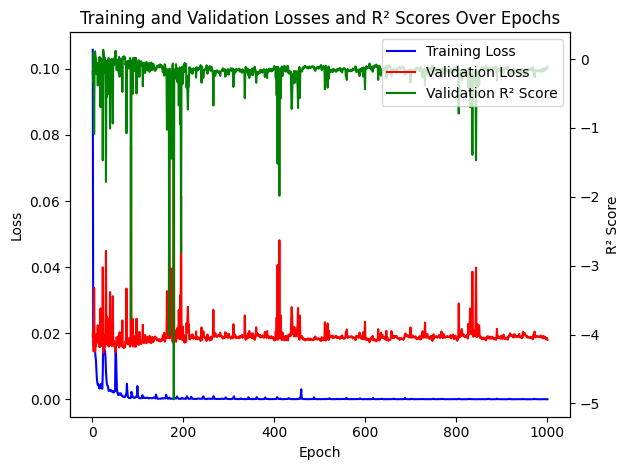

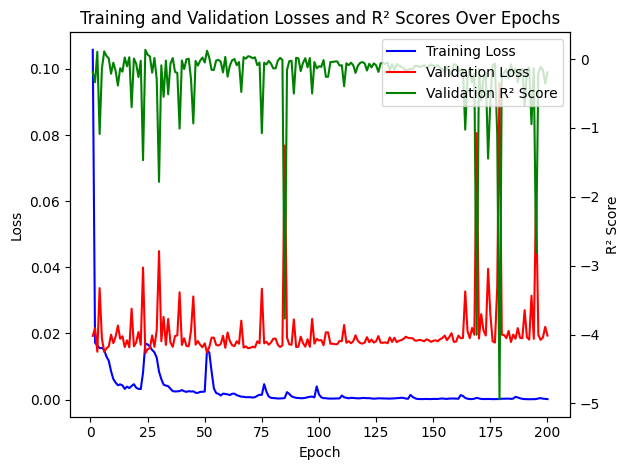

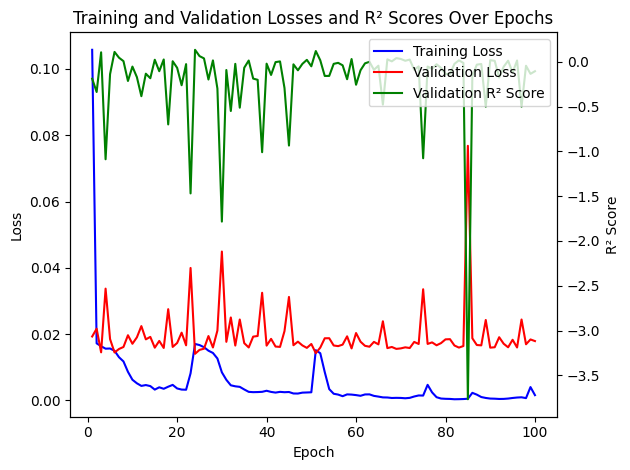

In [131]:
plot_training_progress()
plot_training_progress(200)
plot_training_progress(100)